# Try the interpolation on synthetic data

In [1]:
import xarray as xr
import pandas as pd
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import pyproj
import numpy as np
from dask.distributed import Client
import verde as vd
from vector3d import Vector3D, vector3d_jacobian
from vector3d.utils import plot_data, combinations, sample_from_grid, longitude_shift

In [2]:
data = xr.open_dataset('../../data/synthetic-california.nc')
region = vd.get_region((data.longitude.values, data.latitude.values))
spacing = (data.latitude[1] - data.latitude[0]).values
data

<xarray.Dataset>
Dimensions:         (latitude: 116, longitude: 112)
Coordinates:
  * longitude       (longitude) float64 235.7 235.8 235.9 235.9 236.0 236.1 ...
  * latitude        (latitude) float64 32.29 32.37 32.46 32.54 32.62 32.71 ...
Data variables:
    east_velocity   (latitude, longitude) float64 ...
    north_velocity  (latitude, longitude) float64 ...
    up_velocity     (latitude, longitude) float64 ...
Attributes:
    metadata:  Generated by Chain(steps=[('mean', BlockReduce(adjust='spacing...

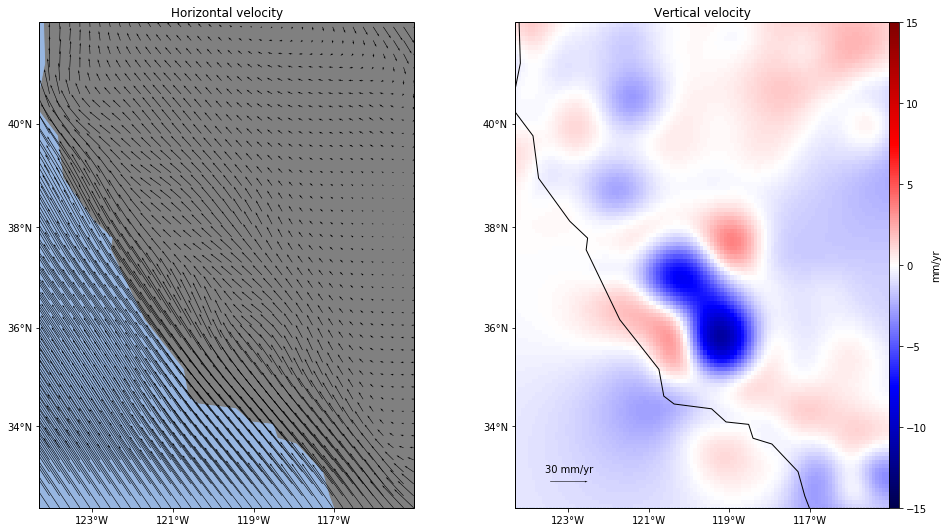

In [3]:
fig, axes = plot_data(data, every=3, maxabs=15)

Setup a map projection.

In [4]:
proj = pyproj.Proj(proj='merc', lat_ts=data.latitude.mean())

## Sample the synthetic data

Take the samples as the nearest neighbors of the real data points.

In [5]:
real_data = vd.datasets.fetch_california_gps()
real_data.head()

,latitude,longitude,height,velocity_north,velocity_east,velocity_up,std_north,std_east,std_up
0,34.116409,242.906804,762.11978,0.01648,-0.01573,0.00261,0.0002,0.00037,0.00053
1,34.116409,242.906804,762.10883,0.01648,-0.01573,0.00261,0.0002,0.00037,0.00053
2,34.116409,242.906805,762.09364,0.01648,-0.01573,0.00261,0.0002,0.00037,0.00053
3,34.116409,242.906805,762.09073,0.01648,-0.01573,0.00261,0.0002,0.00037,0.00053
4,34.116409,242.906805,762.07699,0.01648,-0.01573,0.00261,0.0002,0.00037,0.00053


In [6]:
sample = sample_from_grid(data, dict(longitude=real_data.longitude, latitude=real_data.latitude))
sample.head()

,east_velocity,north_velocity,up_velocity,longitude,latitude
0,-15.492473,18.146637,1.279084,242.878947,34.12763
1,-15.492473,18.146637,1.279084,242.878947,34.12763
2,-15.492473,18.146637,1.279084,242.878947,34.12763
3,-15.492473,18.146637,1.279084,242.878947,34.12763
4,-15.492473,18.146637,1.279084,242.878947,34.12763


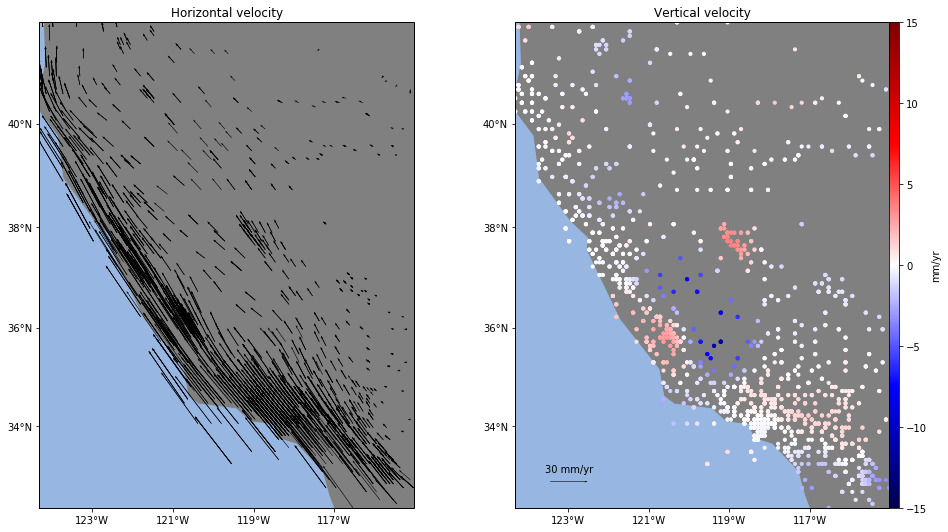

In [7]:
fig, axes = plot_data(sample, maxabs=15)

## Simple gridding

In [8]:
train = (proj(sample.longitude.values, sample.latitude.values), 
         (sample.east_velocity, sample.north_velocity, sample.up_velocity))
test = (proj(*np.meshgrid(data.longitude, data.latitude)), 
         (data.east_velocity.values, data.north_velocity.values, data.up_velocity.values))

In [9]:
spacing = 5/60

In [10]:
chain = vd.Chain([
    ('mean', vd.BlockReduce(np.mean, spacing=spacing*100e3)),
    ('trend', vd.VectorTrend(1)),
    ('spline', Vector3D(depth=100e3, poisson=0.5, damping=1e1))
])
chain.fit(*train)
score = chain.score(*test)
print("R2 score:", score)

R2 score: 0.9888874727105419


In [11]:
grid = chain.grid(region=region, spacing=spacing, projection=proj,
                  dims=['latitude', 'longitude'], 
                  data_names=['east_velocity', 'north_velocity', 'up_velocity'])
grid

<xarray.Dataset>
Dimensions:         (latitude: 116, longitude: 112)
Coordinates:
  * longitude       (longitude) float64 235.7 235.8 235.9 235.9 236.0 236.1 ...
  * latitude        (latitude) float64 32.29 32.37 32.46 32.54 32.62 32.71 ...
Data variables:
    east_velocity   (latitude, longitude) float64 -45.26 -45.03 -44.79 ...
    north_velocity  (latitude, longitude) float64 56.54 56.24 55.95 55.65 ...
    up_velocity     (latitude, longitude) float64 -0.6314 -0.6368 -0.6424 ...
Attributes:
    metadata:  Generated by Chain(steps=[('mean', BlockReduce(adjust='spacing...

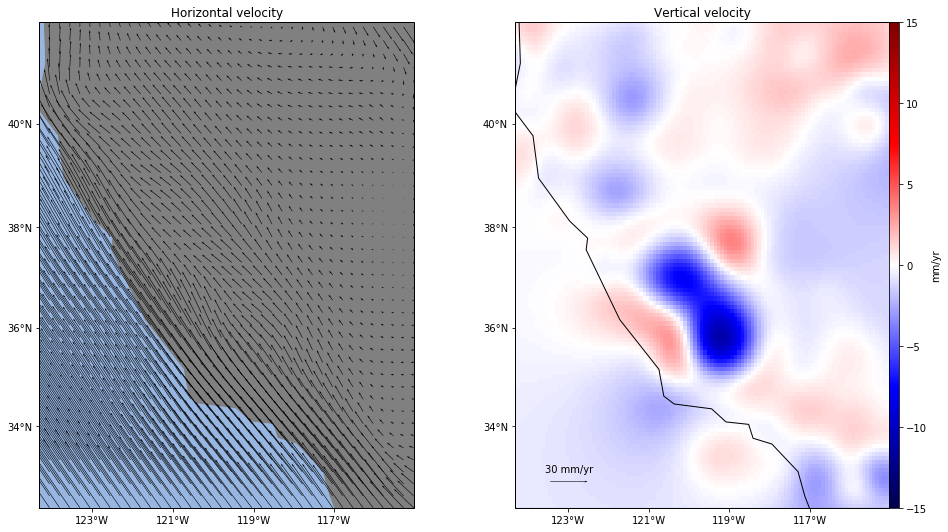

In [18]:
fig, axes = plot_data(grid, every=3, maxabs=15)

In [13]:
def make_residuals(gridder):
    predicted = gridder.predict(proj(*np.meshgrid(data.longitude, data.latitude)))
    names = ['east_velocity', 'north_velocity', 'up_velocity']
    pred = xr.Dataset({name: (['latitude', 'longitude'], comp)
                       for name, comp in zip(names, predicted)}, 
                      coords=data.coords)
    return data - pred

In [14]:
residuals = make_residuals(chain)
residuals

<xarray.Dataset>
Dimensions:         (latitude: 116, longitude: 112)
Coordinates:
  * longitude       (longitude) float64 235.7 235.8 235.9 235.9 236.0 236.1 ...
  * latitude        (latitude) float64 32.29 32.37 32.46 32.54 32.62 32.71 ...
Data variables:
    east_velocity   (latitude, longitude) float64 0.3917 0.3887 0.3854 ...
    north_velocity  (latitude, longitude) float64 0.7233 0.7369 0.7506 ...
    up_velocity     (latitude, longitude) float64 -0.08627 -0.09209 -0.09799 ...

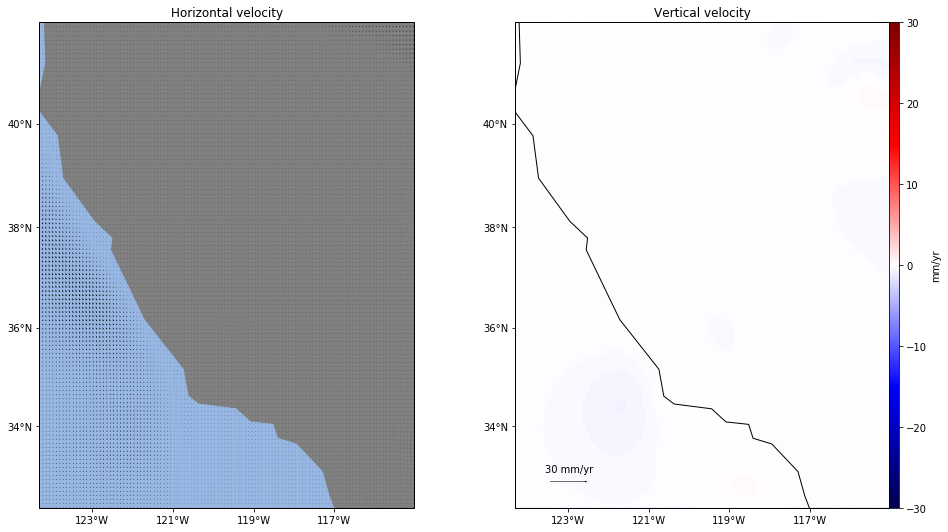

In [15]:
fig, axes = plot_data(residuals, every=1, maxabs=30)